# Import Library

In [3]:

import time
import glob
import datetime
import random
import pickle
import numpy as np
import shutil
import os
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1) # (A)
import keras.optimizers  # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from decimal import *
from keras.layers.recurrent import SimpleRNN, LSTM
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Make Train Data

In [24]:
def make_data(daw_p,df,STRIDE):
    num_var = 1 + STRIDE
    RATE = 0.8
    x_ = []
    y_ = []
    
    df_con = pd.concat([daw_p,df],axis = 1,join='inner')
    col_ = df_con.columns
#     df_con=df_con.astype(float)
    
    for i in range(1+STRIDE,len(df_con)-1):
        
        li    = np.array([0.0 for i in range(num_var)])
        for j in range(i-STRIDE,i):
            li[j-i+STRIDE] = df_con.iloc[j,3]*100
        li[-1] = df_con.index.weekday[i]
        x_.append(li)
        
        if df_con.iloc[i+1,7] - df_con.iloc[i+1,4]>0:
            y_.append([0,1])
        else:
            y_.append([1,0])
    
    return np.array(x_),np.array(y_)
    
    
    
    

# Load DF

In [5]:
def load_df(path_):

    FILE = glob.glob(path_)
    df = pd.read_csv(FILE[0])
    df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'dopen',\
                                df.columns[6]:'dhigh',df.columns[7]:'dlow',df.columns[8]:'dclose',\
                                   df.columns[9]:'nan',})

    df = df.drop('nan',axis=1)
    df = df.drop(df.index[0])
    df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
    df.set_index('day',inplace=True)
    
    return df.astype(float)

In [6]:
path_ = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'

df_daw = load_df(path_)
daw_p = df_daw.pct_change()
path2 = '/Users/rince/Desktop/StockPriceData/Stock_index/NFNK225_10years.csv'
df_nf225 = load_df(path2)

In [25]:
x_,y_ = make_data(daw_p,df_nf225,STRIDE=5)

In [26]:
print(sum(y_[:,0]))
print(sum(y_[:,1]))

1221
1157


In [27]:
print(x_train.shape)
print(y_train.shape)

(1902, 6)
(1902,)


In [28]:
length = len(x_)
RATE = int(0.8*length)

x_train,y_train = x_[:RATE],y_[:RATE]
x_test,y_test = x_[RATE:],y_[RATE:]
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_train.shape[1])
y_train = np.argmax(y_train,axis=1)
y_test = np.argmax(y_test,axis=1)

# XGB predict

In [22]:
def xgb_pred(x_train,y_train,x_test,y_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    param = {'eta': 0.09107858292565747, 'max_depth': 6, 'lambda': 0.9335155074430995, 'objective': 'multi:softmax', 'num_class': 3}  

    num_round = 30
    bst = xgb.train(param, dtrain,num_round)  
#     bst = xgb.train(param, dtrain,num_round)  
    # bst = xgb.train(dtrain)

    dtest = xgb.DMatrix(x_test)  
    pred = bst.predict(dtest)  

    score = accuracy_score(y_test, pred)  
    print('score:{0:.4f}'.format(score))  

    #     xgb.plot_importance(bst)  

    dtest = xgb.DMatrix(x_test)  
    predict_classes = bst.predict(dtest)  

    true_classes = y_test
    plt.clf()
    cmx = confusion_matrix(true_classes, predict_classes)
    sns.heatmap(cmx, annot=True, fmt='g', square=True)
    plt.show()
    xgb.plot_importance(bst)  
    plt.show()
    
    return bst

[00:26:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score:0.5126


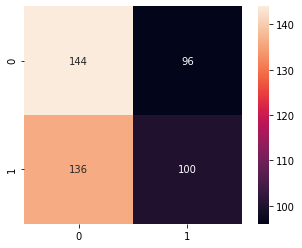

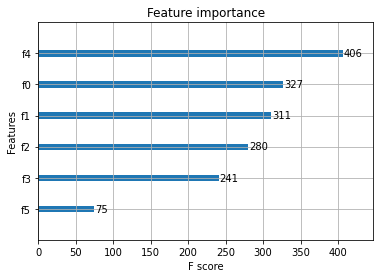

In [29]:
bst = xgb_pred(x_train,y_train,x_test,y_test)